# Regression

In this notebook, we will present the metrics that can be used in regression.

A set of metrics are dedicated to regression. Indeed, classification metrics
cannot be used to evaluate the generalization performance of regression models
because there is a fundamental difference between their target type `target`:
it is a continuous variable in regression, while a discrete variable in
classification.

We will use the Ames housing dataset. The goal is to predict the price
of houses in the city of Ames, Iowa. As with classification, we will only use
a single train-test split to focus solely on the regression metrics.

In [1]:
import pandas as pd
import numpy as np

ames_housing = pd.read_csv("../datasets/house_prices.csv")
data = ames_housing.drop(columns="SalePrice")
target = ames_housing["SalePrice"]
data = data.select_dtypes(np.number)
target /= 1000

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

Let's start by splitting our dataset intro a train and test set.

In [2]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0
)

Some machine learning models are designed to be solved as an optimization
problem: minimizing an error (also known as the loss function) using a
training set.
A basic loss function used in regression is the mean squared error (MSE).
Thus, this metric is sometimes used to evaluate the model since it is
optimized by said model.

We will give an example using a linear regression model.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regressor = LinearRegression()
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_train)

print(f"Mean squared error on the training set: "
      f"{mean_squared_error(target_train, target_predicted):.3f}")

Mean squared error on the training set: 996.902


Our linear regression model is minimizing the mean squared error on the
training set. It means that there is no other set of coefficients which
will decrease the error.

Then, we can compute the mean squared error on the test set.

In [4]:
target_predicted = regressor.predict(data_test)

print(f"Mean squared error on the testing set: "
      f"{mean_squared_error(target_test, target_predicted):.3f}")

Mean squared error on the testing set: 2064.736


The raw MSE can be difficult to interpret. One way is to rescale the MSE
by the variance of the target. This score is known as the $R^2$ also called
the coefficient of determination. Indeed, this is the default score used
in scikit-learn by calling the method `score`.

In [5]:
regressor.score(data_test, target_test)

0.6872520581075483

The $R^2$ score represents the proportion of variance of the target that is
explained by the independent variables in the model. The best score possible
is 1 but there is no lower bound. However, a model that predicts the expected
value of the target would get a score of 0.

In [6]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(data_train, target_train)
print(f"R2 score for a regressor predicting the mean:"
      f"{dummy_regressor.score(data_test, target_test):.3f}")

R2 score for a regressor predicting the mean:-0.000


The $R^2$ score gives insight into the quality of the model's fit. However,
this score cannot be compared from one dataset to another and the value
obtained does not have a meaningful interpretation relative the original unit
of the target. If we wanted to get an interpretable score, we would be
interested in the median or mean absolute error.

In [7]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data_test)
print(f"Mean absolute error: "
      f"{mean_absolute_error(target_test, target_predicted):.3f} k$")

Mean absolute error: 22.608 k$


By computing the mean absolute error, we can interpret that our model is
predicting on average 22.6 k\\$ away from the true house price. A disadvantage
of this metric is that the mean can be impacted by large error. For some
applications, we might not want these large errors to have such a big
influence on our metric. In this case we can use the median absolute error.

In [8]:
from sklearn.metrics import median_absolute_error

print(f"Median absolute error: "
      f"{median_absolute_error(target_test, target_predicted):.3f} k$")

Median absolute error: 14.137 k$


The mean absolute error (or median absolute error) still have a known
limitation: committing an error of 50 k\\$ for a house valued at 50 k\\$ has the
same impact than committing an error of 50 k\\$ for a house valued at 500 k\\$.
Indeed, the mean absolute error is not relative.

The mean absolute percentage error introduce this relative scaling.

In [9]:
from sklearn.metrics import mean_absolute_percentage_error

print(f"Mean absolute percentage error: "
      f"{mean_absolute_percentage_error(target_test, target_predicted) * 100:.3f} %")

Mean absolute percentage error: 13.574 %


In addition of metrics, we can visually represent the results by plotting
the predicted values versus the true values.

In [10]:
predicted_actual = {
    "True values (k$)": target_test, "Predicted values (k$)": target_predicted}
predicted_actual = pd.DataFrame(predicted_actual)

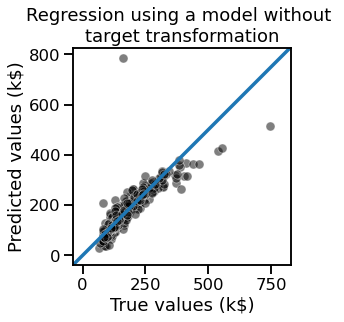

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=predicted_actual,
                x="True values (k$)", y="Predicted values (k$)",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Regression using a model without \ntarget transformation")

On this plot, correct predictions would lie on the diagonal line. This plot
allows us to detect if the model makes errors in a consistent way, i.e.
has some bias.

On this plot, we see that for the large True price values, our model tends to
under-estimate the price of the house. Typically, this issue arises when the
target to predict does not follow a normal distribution. In this case the
model would benefit from target transformation.

In [12]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

transformer = QuantileTransformer(
    n_quantiles=900, output_distribution="normal")
model_transformed_target = TransformedTargetRegressor(
    regressor=regressor, transformer=transformer)
model_transformed_target.fit(data_train, target_train)
target_predicted = model_transformed_target.predict(data_test)

In [13]:
predicted_actual = {
    "True values (k$)": target_test, "Predicted values (k$)": target_predicted}
predicted_actual = pd.DataFrame(predicted_actual)

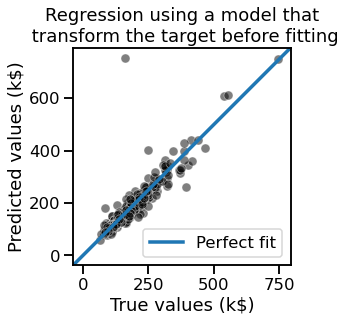

In [14]:
sns.scatterplot(data=predicted_actual,
                x="True values (k$)", y="Predicted values (k$)",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
plt.legend()
_ = plt.title("Regression using a model that\n transform the target before "
              "fitting")

Thus, once we transformed the target, we see that we corrected some of the
high values.